In [1]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
binary_labels_map = {
    0: "REAL",
    1: "FAKE"
}
with open(os.path.join(script_dir, '../dataset/imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 324k samples for training
train_ds = functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../dataset/stable_diffusion_1_4/train'), transform=transform)

# 6k samples for validation and 6k samples for testing
val_ground_truth = functions.val_mapping(os.path.join(script_dir, '../dataset'))
val_test_ds= functions.MulticlassGenImage(img_dir=os.path.join(script_dir, '../dataset/stable_diffusion_1_4/val'), val_gt=val_ground_truth, transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['binary']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

cuda:0


# Model training

### Untrained model

/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_untrained_batch64
- Epoch 1: current lr = 1e-03
Train error: Combined=97.39%; Binary=14.09%; multiclass=97.11%; 
Validation error: Combined=97.45%; Binary=13.68%; multiclass=97.30%; 
Loss: 6.993e+00
- Epoch 2: current lr = 1e-03
Train error: Combined=89.96%; Binary=12.65%; multiclass=88.06%; 
Validation error: Combined=90.33%; Binary=13.18%; multiclass=88.43%; 
Loss: 5.675e+00
- Epoch 3: current lr = 1e-03
Train error: Combined=92.73%; Binary=29.68%; multiclass=88.37%; 
Validation error: Combined=93.18%; Binary=29.93%; multiclass=88.92%; 
Loss: 4.726e+00
- Epoch 4: current lr = 1e-03
Train error: Combined=79.42%; Binary=38.28%; multiclass=77.34%; 
Validation error: Combined=79.62%; Binary=38.70%; multiclass=77.83%; 
Loss: 4.079e+00
- Epoch 5: current lr = 1e-03
Train error: Combined=74.97%; Binary=15.39%; multiclass=69.03%; 
Validation error: Combined=77.02%; Binary=16.07%; multiclass=71.03%; 
Loss: 3.625e+00


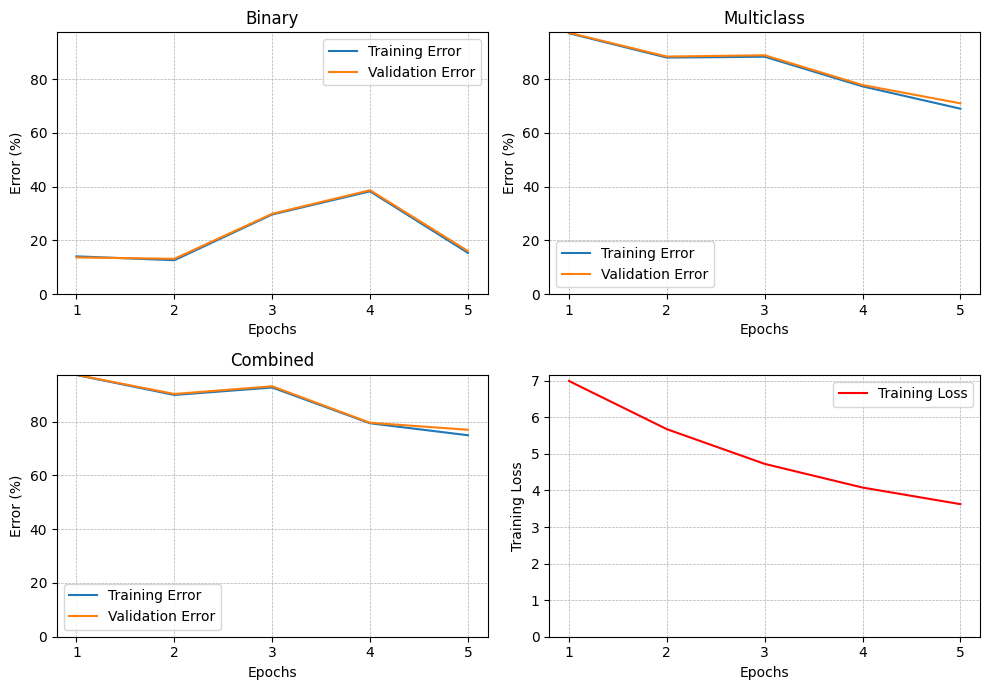

In [3]:
model_init_function = models.multiclass_untrained
epochs = 5
batch_size = 64
lr = 0.001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=8)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

### Finetuning of the model

/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_finetuning_batch64
- Epoch 1: current lr = 1e-03
Train error: Combined=17.73%; Binary=2.04%; multiclass=16.18%; 
Validation error: Combined=22.23%; Binary=2.38%; multiclass=20.38%; 
Loss: 2.576e+00
- Epoch 2: current lr = 1e-03
Train error: Combined=11.66%; Binary=0.79%; multiclass=11.02%; 
Validation error: Combined=18.30%; Binary=1.28%; multiclass=17.28%; 
Loss: 7.123e-01
- Epoch 3: current lr = 1e-03
Train error: Combined=8.69%; Binary=0.39%; multiclass=8.36%; 
Validation error: Combined=17.07%; Binary=1.05%; multiclass=16.20%; 
Loss: 5.134e-01
- Epoch 4: current lr = 1e-03
Train error: Combined=6.84%; Binary=0.19%; multiclass=6.67%; 
Validation error: Combined=16.42%; Binary=0.95%; multiclass=15.68%; 
Loss: 4.022e-01
- Epoch 5: current lr = 1e-03
Train error: Combined=5.18%; Binary=0.09%; multiclass=5.10%; 
Validation error: Combined=15.72%; Binary=0.65%; multiclass=15.17%; 
Loss: 3.251e-01


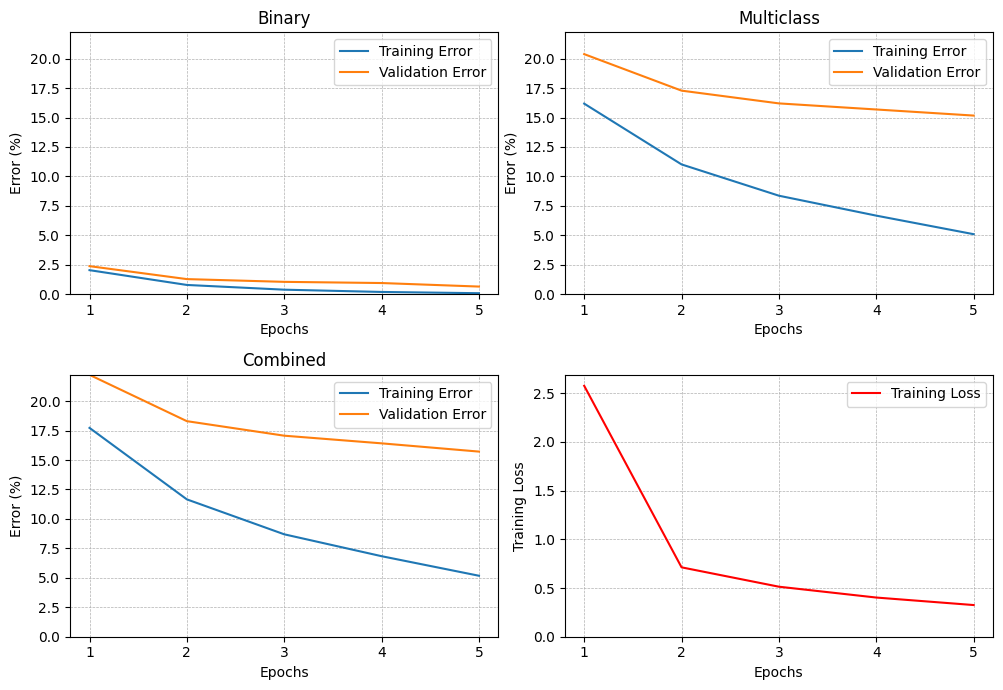

In [3]:
model_init_function = models.multiclass_finetuning
epochs = 5
batch_size = 64
lr = 0.001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=8)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

### Finetuning of the model with 1 additional fc layer

/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_finetuning_1hidden_batch64
- Epoch 1: current lr = 1e-03
Train error: Combined=22.37%; Binary=1.93%; multiclass=20.94%; 
Validation error: Combined=26.32%; Binary=2.15%; multiclass=24.78%; 
Loss: 4.070e+00
- Epoch 2: current lr = 1e-03
Train error: Combined=13.51%; Binary=0.82%; multiclass=12.83%; 
Validation error: Combined=19.77%; Binary=1.47%; multiclass=18.63%; 
Loss: 9.612e-01
- Epoch 3: current lr = 1e-03
Train error: Combined=9.98%; Binary=0.40%; multiclass=9.64%; 
Validation error: Combined=17.40%; Binary=0.88%; multiclass=16.70%; 
Loss: 6.406e-01
- Epoch 4: current lr = 1e-03
Train error: Combined=8.04%; Binary=0.30%; multiclass=7.77%; 
Validation error: Combined=17.05%; Binary=0.95%; multiclass=16.27%; 
Loss: 4.917e-01
- Epoch 5: current lr = 1e-03
Train error: Combined=6.09%; Binary=0.18%; multiclass=5.92%; 
Validation error: Combined=16.53%; Binary=0.88%; multiclass=15.82%; 
Loss: 3.899e-01


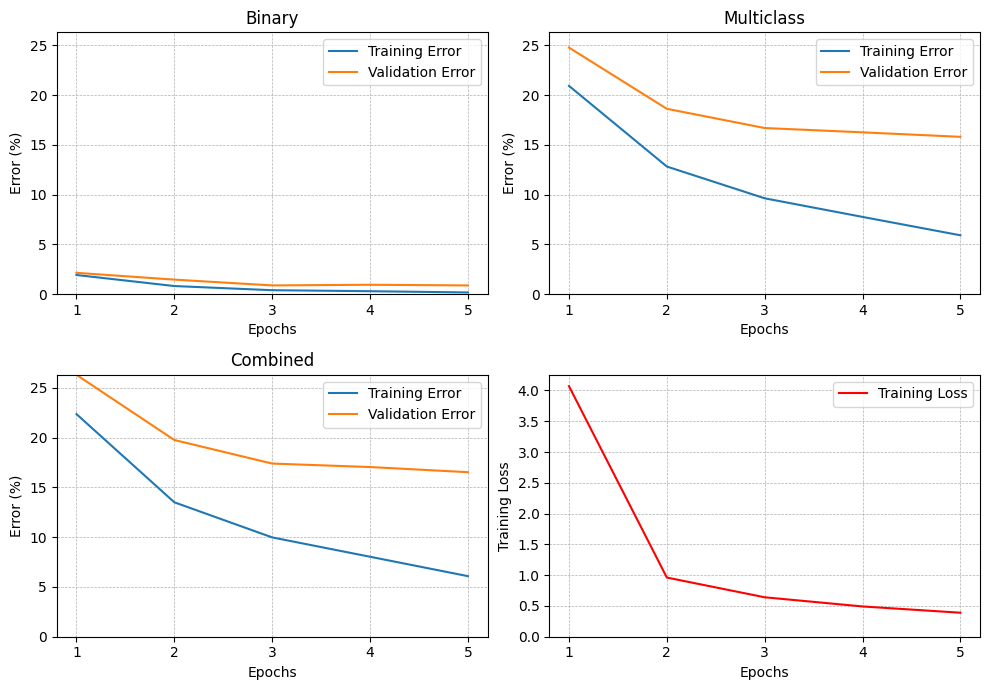

In [3]:
model_init_function = models.multiclass_finetuning_1hidden
epochs = 5
batch_size = 64
lr = 0.001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=8)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)

## 90 epochs of training of the model initialized with standard weights and no additional fc layers

/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_finetuning_batch64


- Epoch 1: current lr = 1e-02
Train error: Combined=14.87%; Binary=1.73%; multiclass=13.50%; 
Validation error: Combined=22.78%; Binary=2.08%; multiclass=21.12%; 
Loss: 1.153e+00


- Epoch 2: current lr = 1e-02
Train error: Combined=10.96%; Binary=1.06%; multiclass=10.05%; 
Validation error: Combined=23.05%; Binary=1.55%; multiclass=21.92%; 
Loss: 5.700e-01


- Epoch 3: current lr = 1e-02
Train error: Combined=8.54%; Binary=0.83%; multiclass=7.79%; 
Validation error: Combined=21.58%; Binary=1.60%; multiclass=20.47%; 
Loss: 4.258e-01


- Epoch 4: current lr = 1e-02
Train error: Combined=8.70%; Binary=1.32%; multiclass=7.54%; 
Validation error: Combined=23.73%; Binary=2.33%; multiclass=22.05%; 
Loss: 3.467e-01


- Epoch 5: current lr = 1e-02
Train error: Combined=7.83%; Binary=1.34%; multiclass=6.63%; 
Validation error: Combined=23.52%; Binary=2.10%; multiclass=21.90%; 
Loss: 2.948e-01


- Epoch 10: current lr = 1e-02
Train error: Combined=6.63%; Binary=0.60%; multiclass=6.10%; 
Validation error: Combined=25.23%; Binary=1.48%; multiclass=24.13%; 
Loss: 2.143e-01


- Epoch 15: current lr = 1e-03
Train error: Combined=0.08%; Binary=0.00%; multiclass=0.08%; 
Validation error: Combined=18.20%; Binary=0.47%; multiclass=17.85%; 
Loss: 2.464e-02


- Epoch 20: current lr = 1e-03
Train error: Combined=0.04%; Binary=0.00%; multiclass=0.04%; 
Validation error: Combined=17.83%; Binary=0.52%; multiclass=17.43%; 
Loss: 1.351e-02


- Epoch 25: current lr = 1e-03
Train error: Combined=0.04%; Binary=0.00%; multiclass=0.04%; 
Validation error: Combined=17.67%; Binary=0.40%; multiclass=17.35%; 
Loss: 1.063e-02


- Epoch 30: current lr = 1e-04
Train error: Combined=0.04%; Binary=0.00%; multiclass=0.04%; 
Validation error: Combined=17.73%; Binary=0.40%; multiclass=17.42%; 
Loss: 9.285e-03


- Epoch 35: current lr = 1e-04
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.62%; Binary=0.35%; multiclass=17.35%; 
Loss: 9.170e-03


- Epoch 40: current lr = 1e-05
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.73%; Binary=0.33%; multiclass=17.48%; 
Loss: 9.086e-03


- Epoch 45: current lr = 1e-05
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.80%; Binary=0.42%; multiclass=17.47%; 
Loss: 9.144e-03


- Epoch 50: current lr = 1e-06
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.80%; Binary=0.38%; multiclass=17.52%; 
Loss: 9.120e-03


- Epoch 55: current lr = 1e-06
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.60%; Binary=0.37%; multiclass=17.33%; 
Loss: 9.015e-03


- Epoch 60: current lr = 1e-07
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.77%; Binary=0.37%; multiclass=17.47%; 
Loss: 9.114e-03


- Epoch 65: current lr = 1e-07
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.75%; Binary=0.37%; multiclass=17.45%; 
Loss: 9.011e-03


- Epoch 70: current lr = 1e-08
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.87%; Binary=0.33%; multiclass=17.60%; 
Loss: 9.082e-03


- Epoch 75: current lr = 1e-08
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.72%; Binary=0.32%; multiclass=17.45%; 
Loss: 9.073e-03


- Epoch 80: current lr = 1e-08
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.80%; Binary=0.37%; multiclass=17.50%; 
Loss: 9.079e-03


- Epoch 85: current lr = 1e-08
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.78%; Binary=0.33%; multiclass=17.53%; 
Loss: 9.064e-03


- Epoch 90: current lr = 1e-08
Train error: Combined=0.03%; Binary=0.00%; multiclass=0.03%; 
Validation error: Combined=17.72%; Binary=0.38%; multiclass=17.42%; 
Loss: 9.082e-03


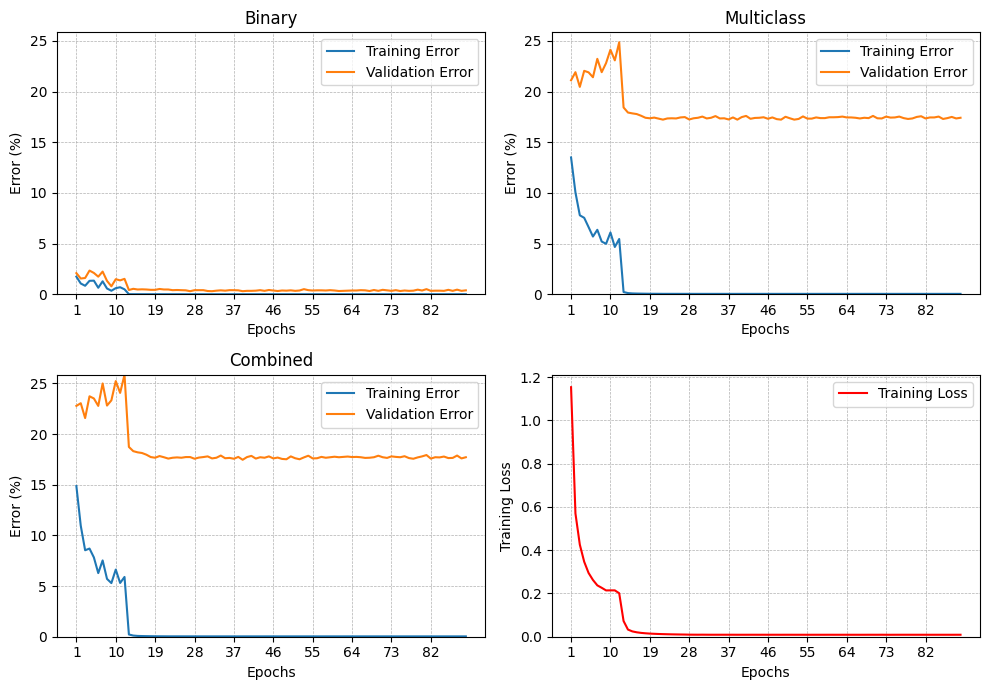

In [ ]:
model_init_function = models.multiclass_finetuning
epochs = 90
batch_size = 64
lr = 0.01
val_batch_size = 64
scheduler_patience=8

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)
writer = SummaryWriter('logs/'+model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl, writer=writer, scheduler_patience=scheduler_patience)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['binary'])}"
writer.close()

# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)